In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from datetime import datetime
import numpy as np
import math
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.metrics import silhouette_score

K-means with log return

In [2]:
data = pd.read_excel('5years_database.xlsx', sheet_name='Data with Vix') #usecols=["Adj Close**", "Volume", "VIX-CLOSE"]
data

,Date,Sp-close,Volume,Vix-close
0,02/22/2023,3991.05,4079320000,22.29
1,02/21/2023,3997.34,4121590000,22.87
2,02/17/2023,4079.09,4045480000,20.02
3,02/16/2023,4090.41,4143660000,20.17
4,02/15/2023,4147.60,4075980000,18.23
...,...,...,...,...
1163,07/09/2018,2784.17,3070060000,12.69
1164,07/06/2018,2759.82,2590250000,13.37
1165,07/05/2018,2736.61,2980160000,14.97
1166,07/03/2018,2713.22,1911460000,16.14


In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y') # convert 'Date' column to datetime
#data.set_index('Date', inplace=True)  # Set the 'Date' column as the index


In [28]:
trading_instrument = 'Sp-close'
fig = px.line(data, x='Date', y='Sp-close', title=f'{trading_instrument} Time Series')
fig.show()

In [4]:
# Calculate log returns
data['sp_log_return'] = np.log(data['Sp-close'] / data['Sp-close'].shift(1))
data.dropna(inplace=True)
data

,Date,Sp-close,Volume,Vix-close,sp_log_return
1,2023-02-21,3997.34,4121590000,22.87,0.001575
2,2023-02-17,4079.09,4045480000,20.02,0.020245
3,2023-02-16,4090.41,4143660000,20.17,0.002771
4,2023-02-15,4147.60,4075980000,18.23,0.013885
5,2023-02-14,4136.13,3929200000,18.91,-0.002769
...,...,...,...,...,...
1163,2018-07-09,2784.17,3070060000,12.69,-0.003467
1164,2018-07-06,2759.82,2590250000,13.37,-0.008784
1165,2018-07-05,2736.61,2980160000,14.97,-0.008446
1166,2018-07-03,2713.22,1911460000,16.14,-0.008584


In [5]:
# Normalize the Close column using min-max scaling
scaler = MinMaxScaler()    #x' = (x - min) / (max - min) Normalization
normalized_columns = ["Norm_Volume", "Norm_Vix_close", "Norm_sp_log_return"]
data[normalized_columns] = scaler.fit_transform(data[["Volume", "Vix-close", "sp_log_return"]])
normalized_columns = ["Norm_Volume", "Norm_Vix_close", 'Norm_sp_log_return']
data

,Date,Sp-close,Volume,Vix-close,sp_log_return,Norm_Volume,Norm_Vix_close,Norm_sp_log_return
1,2023-02-21,3997.34,4121590000,22.87,0.001575,0.325468,0.167316,0.419895
2,2023-02-17,4079.09,4045480000,20.02,0.020245,0.316700,0.127645,0.505799
3,2023-02-16,4090.41,4143660000,20.17,0.002771,0.328011,0.129733,0.425400
4,2023-02-15,4147.60,4075980000,18.23,0.013885,0.320214,0.102728,0.476535
5,2023-02-14,4136.13,3929200000,18.91,-0.002769,0.303303,0.112194,0.399907
...,...,...,...,...,...,...,...,...
1163,2018-07-09,2784.17,3070060000,12.69,-0.003467,0.204324,0.025612,0.396696
1164,2018-07-06,2759.82,2590250000,13.37,-0.008784,0.149046,0.035078,0.372230
1165,2018-07-05,2736.61,2980160000,14.97,-0.008446,0.193967,0.057350,0.373789
1166,2018-07-03,2713.22,1911460000,16.14,-0.008584,0.070845,0.073636,0.373153


Identifying optimal number of clusters

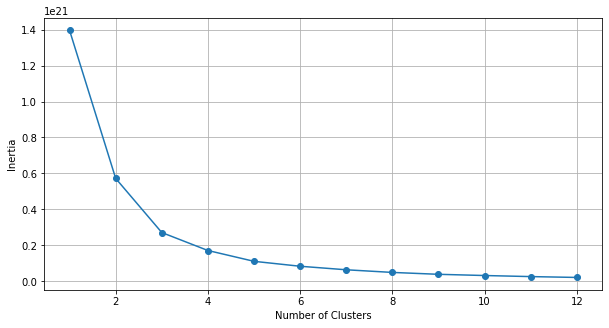

In [9]:
def optimise_k_means(dt, max_k):
    means=[] #the number of clusters used for each model
    inertias=[] #sum of squared distances of samples to their closest cluster center for each model
    for k in range(1, max_k):
        kmeans =  KMeans(n_clusters=k)
        kmeans.fit(dt)

        means.append(k)
        inertias.append(kmeans.inertia_)
        
    #generate the elbow plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
optimise_k_means(data[["Sp-close", "Volume", "Vix-close"]],13)

Perform K-means clustering

In [6]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['kmeans_3'] = kmeans.fit_predict(data[normalized_columns])
data.head(5)

,Date,Sp-close,Volume,Vix-close,sp_log_return,Norm_Volume,Norm_Vix_close,Norm_sp_log_return,kmeans_3
1,2023-02-21,3997.34,4121590000,22.87,0.001575,0.325468,0.167316,0.419895,2
2,2023-02-17,4079.09,4045480000,20.02,0.020245,0.316700,0.127645,0.505799,0
3,2023-02-16,4090.41,4143660000,20.17,0.002771,0.328011,0.129733,0.425400,2
4,2023-02-15,4147.60,4075980000,18.23,0.013885,0.320214,0.102728,0.476535,0
5,2023-02-14,4136.13,3929200000,18.91,-0.002769,0.303303,0.112194,0.399907,0


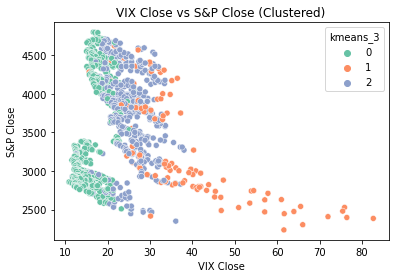

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=data['Vix-close'], y=data['Sp-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlabel('VIX Close')
plt.ylabel('S&P Close')
plt.title('VIX Close vs S&P Close (Clustered)')
plt.show()

In [8]:
#Calculate the mean values of each feature within each cluster
centroids = data.groupby('kmeans_3').mean()
print(centroids)

             Sp-close        Volume  Vix-close  sp_log_return  Norm_Volume  \
kmeans_3                                                                     
0         3415.263526  3.550356e+09  16.284491      -0.000187     0.259658   
1         3273.627921  6.825679e+09  38.223168      -0.000278     0.636999   
2         3747.903790  4.619172e+09  24.827984      -0.000496     0.382793   

          Norm_Vix_close  Norm_sp_log_return  
kmeans_3                                      
0               0.075647            0.411787  
1               0.381030            0.411369  
2               0.194571            0.410366  


In [10]:
# Calculate returns
data['returns'] = data['Sp-close'].pct_change()
data.dropna(inplace=True)

In [11]:
cluster_stats = data.groupby('kmeans_3')['returns'].agg(['mean', 'count'])
cluster_stats['positive_returns'] = (data[data['returns'] > 0]
                                     .groupby('kmeans_3')['returns'].count())
cluster_stats['negative_returns'] = (data[data['returns'] < 0]
                                     .groupby('kmeans_3')['returns'].count())

print(cluster_stats)

              mean  count  positive_returns  negative_returns
kmeans_3                                                     
0        -0.000154    570               261               309
1         0.000233    101                52                49
2        -0.000409    495               230               265


In [18]:
market_regime_map = {
  0: 'Low-volatility',
  1: 'High-volatility',
  2: 'Average-volatility',

}

data['Market Regime'] = data['kmeans_3'].map(market_regime_map)
data.head(4)

,Date,Sp-close,Volume,Vix-close,sp_log_return,Norm_Volume,Norm_Vix_close,Norm_sp_log_return,kmeans_3,returns,Market Regime
2,2023-02-17,4079.09,4045480000,20.02,0.020245,0.316700,0.127645,0.505799,0,0.020451,Low-volatility
3,2023-02-16,4090.41,4143660000,20.17,0.002771,0.328011,0.129733,0.425400,2,0.002775,Average-volatility
4,2023-02-15,4147.60,4075980000,18.23,0.013885,0.320214,0.102728,0.476535,0,0.013981,Low-volatility
5,2023-02-14,4136.13,3929200000,18.91,-0.002769,0.303303,0.112194,0.399907,0,-0.002765,Low-volatility


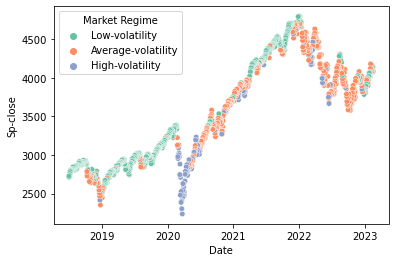

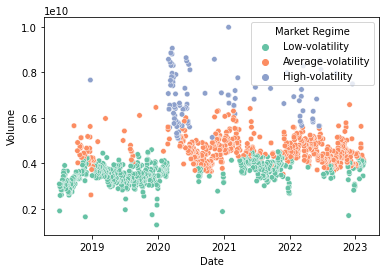

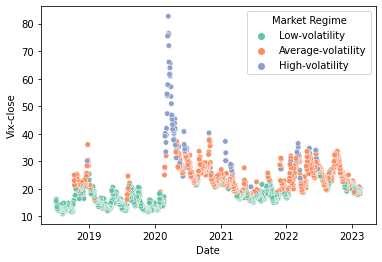

In [20]:
sns.scatterplot(x=data['Date'], y=data['Sp-close'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

sns.scatterplot(x=data['Date'], y=data['Volume'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

sns.scatterplot(x=data['Date'], y=data['Vix-close'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

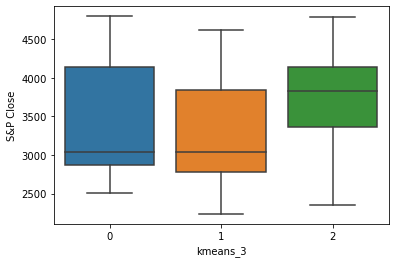

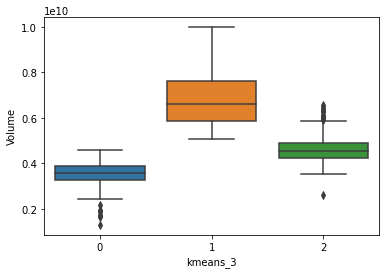

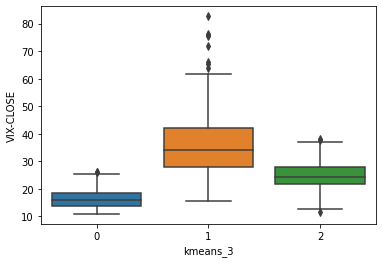

In [17]:
sns.boxplot(x='kmeans_3', y='Sp-close', data=data)
plt.ylabel('S&P Close')
plt.show()

sns.boxplot(x='kmeans_3', y='Volume', data=data)
plt.ylabel('Volume')
plt.show()

sns.boxplot(x='kmeans_3', y='Vix-close', data=data)
plt.ylabel('VIX-CLOSE')
plt.show()